In [1]:
from parchgrad.models.pretrained_models import get_pretrained_model
from parchgrad import get_hook_wrapper
from parchgrad.datasets import get_default_transform
from parchgrad.datasets import IMAGENET_MEAN, IMAGENET_STD, get_datasets
from parchgrad.attribution_methods import get_input_attrib
from parchgrad.bbox.bbox_dataset import BBDataset
from parchgrad.utils import is_there_same_flag
from parchgrad.metric.evaluate_attribution_all import evaluate_attribution_all
import argparse
import os 
import torch 
import time 
import json 
from tqdm import tqdm 
import pickle 
import datetime
from distutils.util import strtobool
from omegaconf import OmegaConf
# --- dataset 
encoder = "efficient_b0"
device="cuda:0"
layer_ratio=1.0
base_dir = f"../outputs/{encoder}"
model = get_pretrained_model(encoder)
model.to(device)
model.eval()
method = 'cls'
wrapper = get_hook_wrapper(encoder, model, method)  # just use cls to gather forward hiddens 
wrapper.prepare_parchgrad(base_directory=base_dir, device=device)

remove_n = len(wrapper.all_convolutions) -  int(layer_ratio * len(wrapper.all_convolutions))
selected_convolutions = wrapper.all_convolutions[remove_n:]
wrapper.set_hook_modules(selected_convolutions)

We set all module's inplace=False
cls_p_value is registered to Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cls_p_value is registered to Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
cls_p_value is registered to Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
cls_p_value is registered to Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
cls_p_value is registered to Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
cls_p_value is registered to Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
cls_p_value is registered to Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
cls_p_value is registered to Conv2d(96, 4, kernel_size=(1, 1), stride=(1, 1))
cls_p_value is registered to Conv2d(4, 96, kernel_size=(1, 1), stride=(1, 1))
cls_p_value is registered to Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
cls_p_value is registered to Conv2d(24,

In [2]:
data_path='/data/ImageNet1k/'
transform = get_default_transform(wrapper.resize, wrapper.crop, IMAGENET_MEAN, IMAGENET_STD)
_, valid_dataset = get_datasets('imagenet1k', data_path, transform)

In [3]:
from omegaconf import OmegaConf

input_attrib='grad'
input_attrib = get_input_attrib(input_attrib)
flags = OmegaConf.create({
    "method" : method,
    'quantile':0.1,
    'alpha' :None,
    'p_value_threshold' : 0.05,
    'variance_conservation' :True, 
    'exact_variance' :False,
     'gamma_infinity': True, 
})
index = 0
x = valid_dataset[index][0].to(device)
y = torch.tensor(valid_dataset[index][1]).to(device).unsqueeze(0)
attr = input_attrib(wrapper, x, y, 
                    cls=y, 
                    modify_gradient=False if flags.method == 'normal' else True,
                    quantile=flags.quantile,
                    alpha=flags.alpha,
                    p_value_threshold=flags.p_value_threshold,
                    variance_conservation=flags.variance_conservation,
                    exact_variance=flags.exact_variance,
                    gamma_infinity=flags.gamma_infinity,
                    enable_forward_hook=True if flags.method == 'ins' else False, 
                    )

4.403782995678887e-06 1.2110955230593051e-06 1.1291645294228532
1.1668789602037238e-06 4.7276631539272446e-06 2.2475643395229166
0.0005168011413024498 0.038537424057822095 8.693052071546651
0.0009956632276134326 0.008447136730055673 3.0795989351994892
0.0002624298505088074 0.009099996648828847 5.972932325085281
2.521571081626123e-07 1e-13 1.0000001982890563
7.936401834296365e-07 1.2443510158801621e-05 4.083997112042542
0.008411177434127195 0.007215439807723625 1.363025842774655
0.0006979264436358345 0.01037466898570524 3.9830878865670325
3.931064939929562e-05 0.0004245514283956719 3.4350995328183678
2.603045322313508e-07 1e-13 1.0000001920826915
7.696103670706751e-07 1.764986164739745e-05 4.892187954378462
0.008847936987976892 0.017742861062388284 1.7335831428662964
0.001435906393553479 0.001860595541174872 1.5151778150751174
0.0002833953477510942 0.002092723036284907 2.895594072736356
6.409842262211558e-07 1e-13 1.0000000780050367
1.1729319885045358e-06 1.33947879566687e-05 3.52419050

torch.Size([224, 224])
tensor(2.7176e-09) tensor(0.0005)


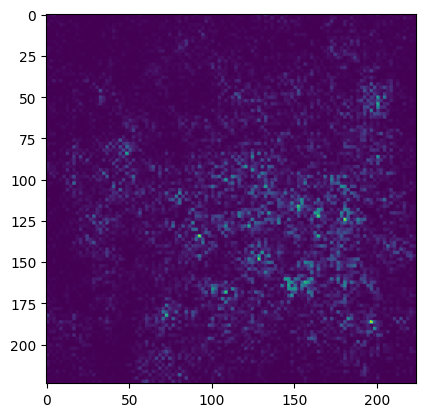

In [4]:
import matplotlib.pyplot as plt 

print(attr.size())
print(attr.min(), attr.max())
plt.imshow(attr)